## Prueba de  Modelos supervisados
![image.png](attachment:95702e4f-3c23-4c14-b887-82214f262d60.png)

#### Pontificia Universidad Católica de Chile
Diplomado en Data Science

Septiembre 2021


### Nombre:
Pablo Opazo 
Mario Guajardo


Utilizaremos un set de datos de las policias de New York del año 2009 y 2010. (`2009_1perc.csv` y `2010_1perc.csv`) los cuales nos darán información de los procedimientos policiales realizados. Además se le entregará el diccionario de variables para que pueda consultar que significa cada categoría dentro de las variables.

- La variable respuesta 'arstmade' informa si los procedimientos policiales han terminado en arresto o no, y el objetivo será realizar un modelo de Machine Learning para predecir si un futuro procedimiento terminará en arresto.

# 1.- Enliste todas las librerias que utilizará (0.5 puntos)
Nota: Se recomienda ir actualizando la lista conforme las necesidades vaya teniendo durante el desarrollo de la prueba

In [239]:
import datetime
import pandas as pd 
import numpy as np 
import missingno as msno
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

# transformacion de datos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # estandarizar
from sklearn.preprocessing import LabelEncoder #cambia categorias a numeros


# librerias de modelacion y metricas
from sklearn.model_selection import GridSearchCV #haremos grillas de hiperparametros con validacion cruzada
from sklearn.model_selection import train_test_split #dividar la base en entranemiento/test
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay #reportes


# librerias de los modelos 
from sklearn.svm import SVC #Super Vector Machine 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # QDA
from sklearn.naive_bayes import MultinomialNB #Naive Bayes

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree



import warnings
warnings.filterwarnings('ignore')

# 2.- Importación y revisión de los datos (1 punto)

Importe ambos sets. Dado que la fuente de datos proviene de la misma base, tienen las mismas columnas. Consolide ambos sets y reporte una exploración *básica* de los datos (numero de filas/columnas, tipos de datos, estadísticas básicas, casos perdidos)

In [240]:
df1 = pd.read_csv("2009_1perc.csv") 
df2 = pd.read_csv("2010_1perc.csv") 
df_consolidado = df1.append(df2)
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11825 entries, 0 to 6012
Columns: 112 entries, Unnamed: 0 to detailcm
dtypes: float64(1), int64(16), object(95)
memory usage: 10.2+ MB


In [241]:
df_consolidado.head(12000) #Formato de DataFrame consolidando los datos del 2009 y 2010

,Unnamed: 0,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,178048,2009,41,1779,4032009,130,A,O,P,1.0,...,,41,G,7,,1013067,0238633,CM,1,20
1,498873,2009,108,5805,10292009,1050,A,O,P,3.0,...,,108,J,,,1012043,0212157,CM,1,14
2,463573,2009,43,8340,10062009,1450,1,O,P,1.0,...,,43,E,,,1017599,0240200,CM,1,20
3,43626,2009,77,932,1232009,1843,A,O,P,5.0,...,,77,J,4,35,1002625,0183442,CM,1,24
4,563921,2009,110,11224,12132009,1655,A,O,P,3.0,...,,110,H,,,1024535,0209890,CM,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,449178,2010,60,7062,9262010,45,1,O,H,2.0,...,,60,I,,,989382,155162,CM,1,20
6009,362162,2010,75,15797,7302010,10,A,O,P,1.0,...,,75,A,,,1012757,186018,CM,1,85
6010,208893,2010,123,830,4302010,1630,A,O,P,3.0,...,,123,E,,,933868,138600,CM,1,46
6011,551820,2010,115,13122,11232010,2100,1,O,P,1.0,...,,115,E,,,1014722,214388,CM,1,85


In [242]:
df_consolidado.shape # Se tienen 11.825 filas y 112 columnas

(11825, 112)

In [243]:
df_consolidado.dtypes 
#Se tiene que a excepción de las Variables "Unnamed:", "year", "pct","ser_num","datestop" las cuales son numericas(int64), 
#el resto de Variables son de tipo Categorica(object). Al revisar se necesitan cambiar el tipo de dato de algunas variables 
#lo cual se realizará mas adelante.

Unnamed: 0     int64
year           int64
pct            int64
ser_num        int64
datestop       int64
               ...  
xcoord        object
ycoord        object
dettypcm      object
linecm        object
detailcm      object
Length: 112, dtype: object

In [244]:
#df_consolidado.describe #Descriptivos Faltan
pd.crosstab(index=df_consolidado['city'], columns="count"),
pd.crosstab(index=df_consolidado['offverb'], columns="count")
df_consolidado['offverb'].unique()

array([' ', 'V'], dtype=object)

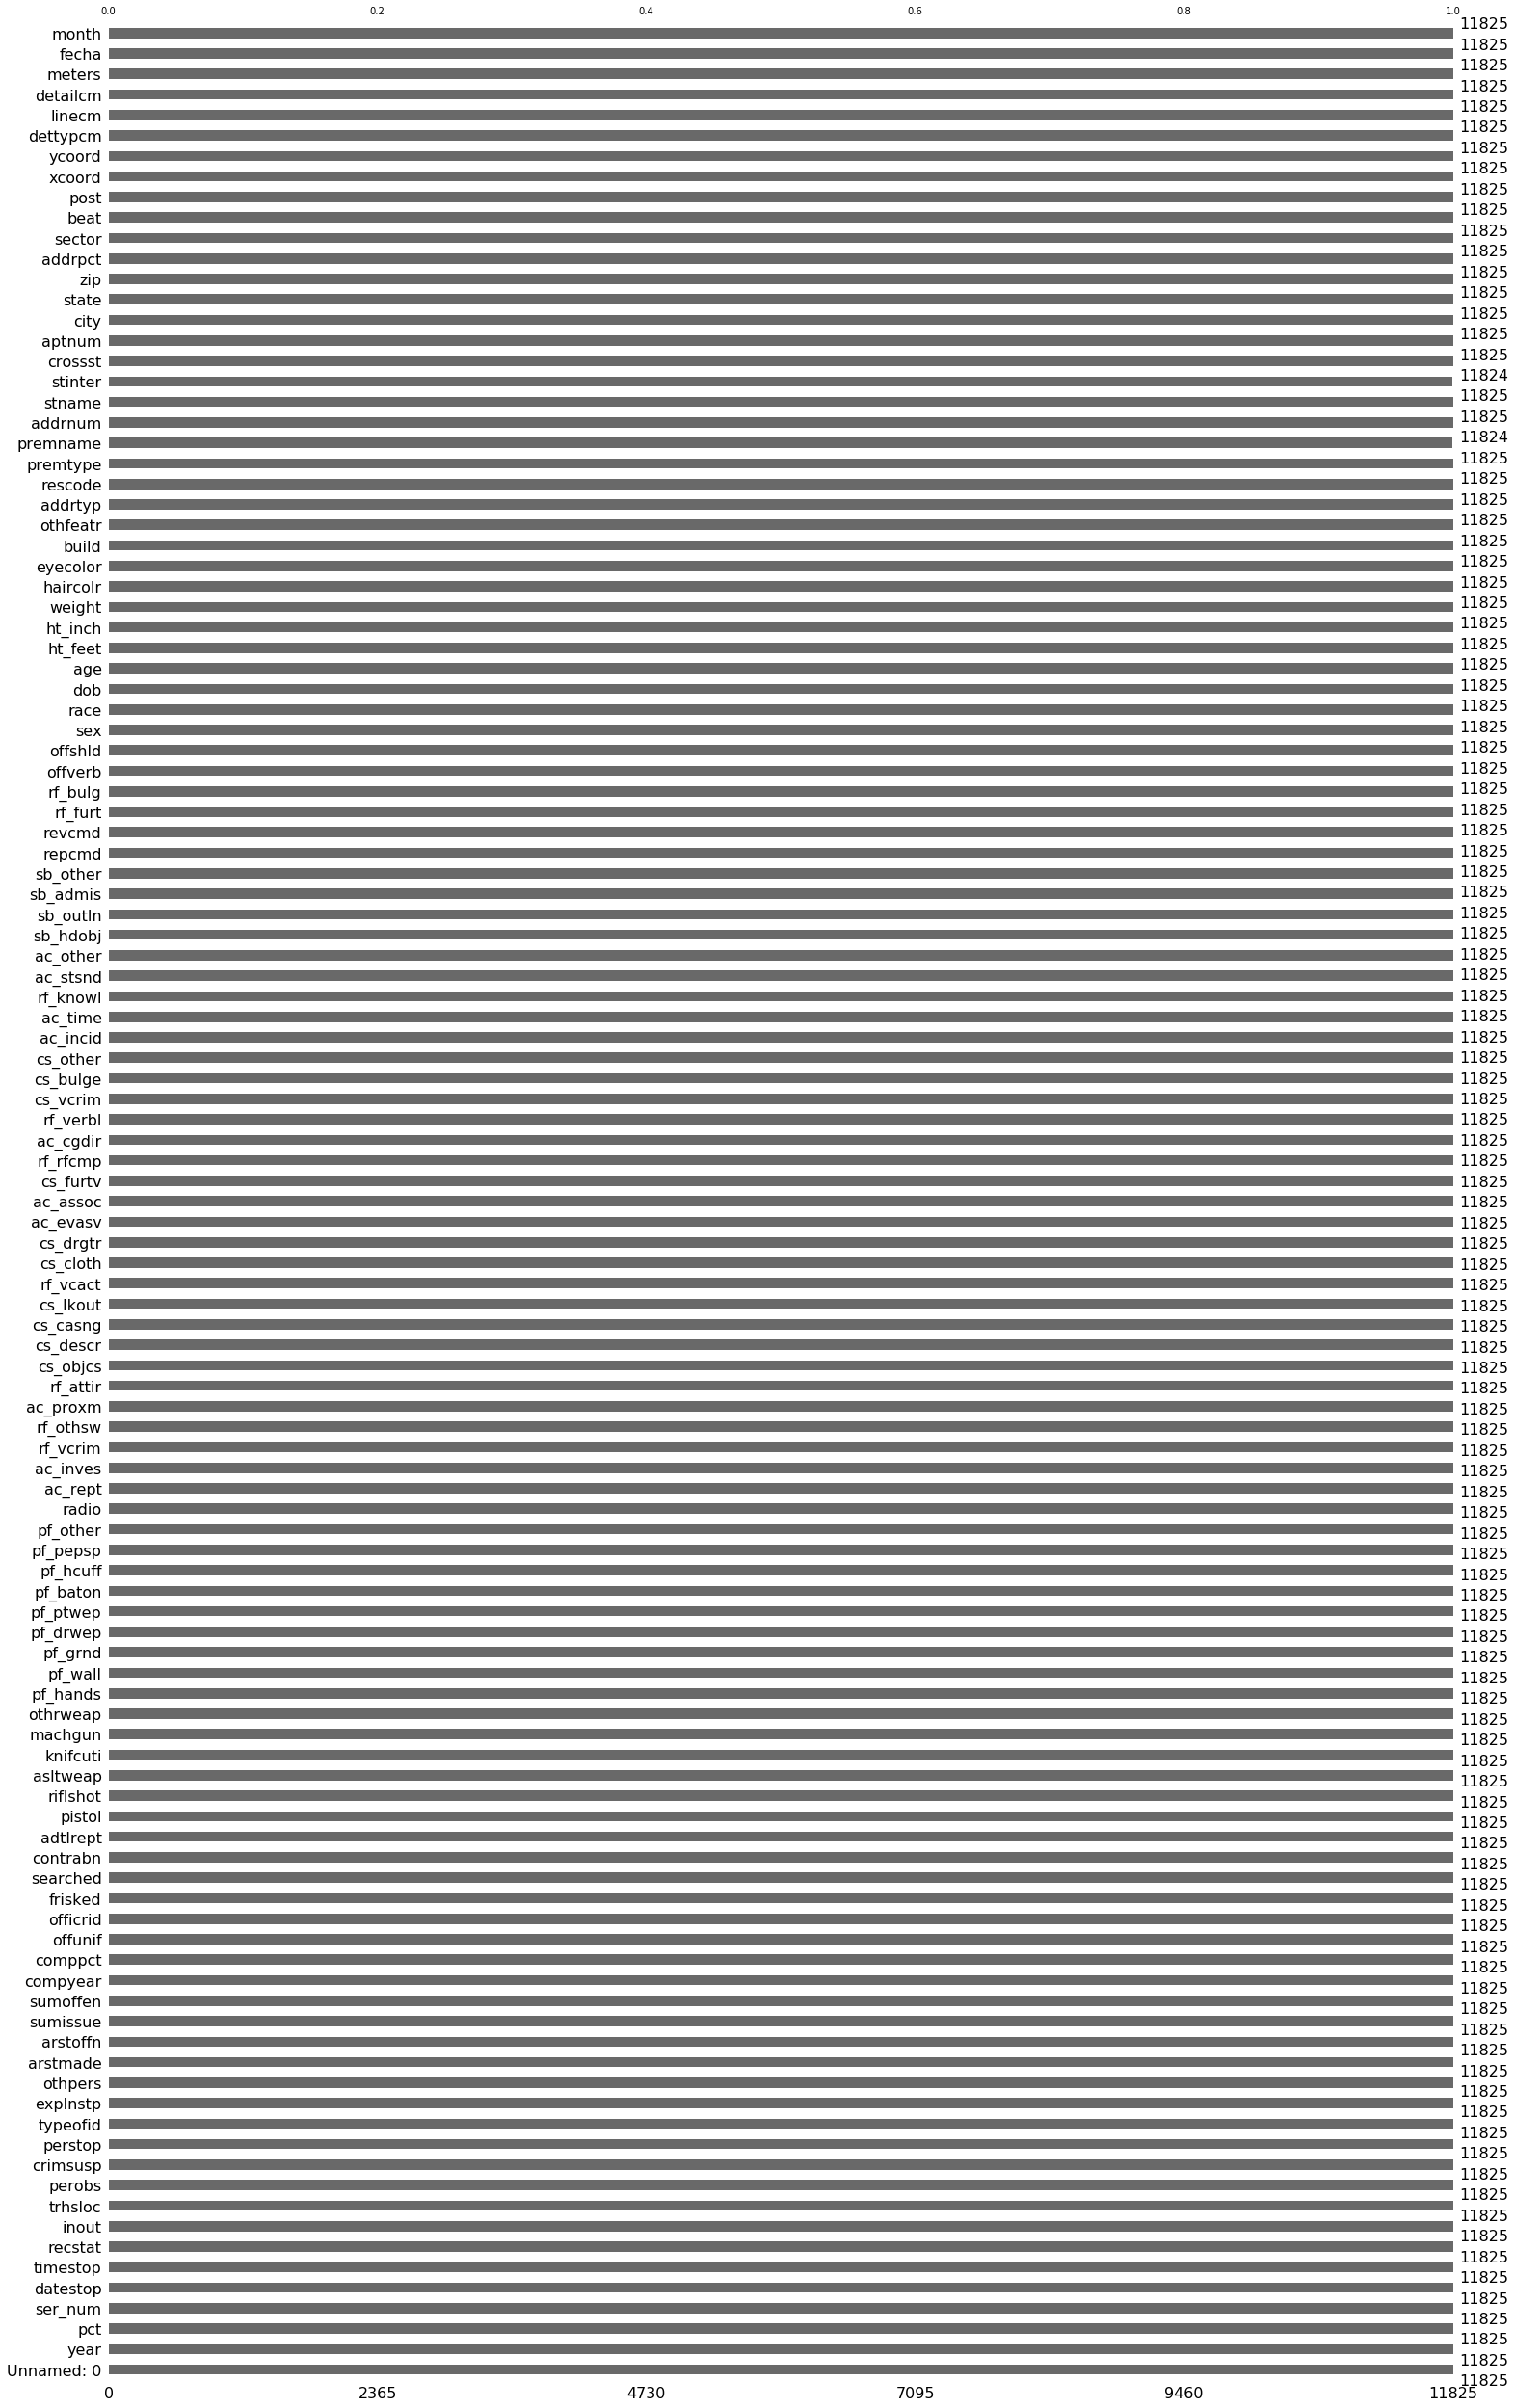

In [283]:
msno.bar(df_consolidado); # El gráfico también nos ayuda a identificar que casi no existen valores perdidos

# 3.- Preprocesamiento de datos (1 punto)
Habrá notado que los datos parecen tener ciertas inconsistencias. Siga los siguientes pasos para limpiar este set:

- 3.1 Obtenga una lista con todas las variables categoricas que tengan entre 2 y 99 categorías (inclusive). (hint: son las variables tipo categoricas

In [246]:
df_categorical = pd.DataFrame()

for column in df_consolidado.select_dtypes(include='object'):
    if df_consolidado[column].nunique() >=2 and df_consolidado[column].nunique() <= 99:
        df_categorical[column] = df_consolidado[column].astype('category')

df_categorical.shape # Se logra encontrar 74 variables categoricas que cumplen con la condición solicitada.

(11825, 74)

- 3.2 Reemplaze las siguientes clases faltantes:

  -Si alguna categoría de las columnas officrid,  o offverb es igual a "" cambielo a 'N' y en caso contrario dejelo como 'Y'
  
  -Si alguna categoría de las columnas sector, trhsloc o beat es igual a "" (o NA, dependiendo de como haya catgado la base de datos), cambielo a 'U' y en caso contrario mantenga su valor
  
Nota, los valores significan {N: No, Y: Yes, U: Unknown}

In [247]:
df_categorical['officrid'] = df_categorical['officrid'].str.replace(' ','N', regex = True)
# df_categorical['offshld'] = df_categorical['offshld'].str.replace(' ','N', regex = True)
df_categorical['offverb'] = df_categorical['offverb'].str.replace(' ','N', regex = True)

df_categorical['sector'] = df_categorical['sector'].str.replace(' ','U', regex = True)
df_categorical['trhsloc'] = df_categorical['trhsloc'].str.replace(' ','U', regex = True)
df_categorical['beat'] = df_categorical['beat'].str.replace(' ','U', regex = True)


- 3.3 Transforme las columnas ht_feet junto con ht_inch en una única columna (de la forma "ht_feet.ht_inch") llamado 'meters' (hint: transforme con el siguiente cálculo: metros = (pies+pulgadas)*0.3048)

In [248]:
def transform_metrics(feet, inch):
    return (feet *  0.3048 + inch *0.0254)

df_consolidado['meters'] = df_consolidado.apply(lambda x : transform_metrics(x['ht_feet'], x['ht_inch']), axis=1)
df_consolidado['meters'] 

0       1.7526
1       1.6510
2       1.9050
3       1.6510
4       1.6764
         ...  
6008    1.7780
6009    1.7018
6010    1.8288
6011    1.8034
6012    1.8542
Name: meters, Length: 11825, dtype: float64

- 3.4 Note que la fecha viene en un formato MMDDAAAA en la columna datestop. Genere 2 nuevas columnas llamadas month y year que solo tenga el mes y el año respectivamente.



In [249]:
df_consolidado['fecha'] = pd.to_datetime(df_consolidado['datestop'], format= '%m%d%Y')
df_consolidado['month'] = pd.DatetimeIndex(df_consolidado['fecha']).month
df_consolidado['month'].head()

0     4
1    10
2    10
3    12
4    12
Name: month, dtype: int64

> Respuesta: Se crea la columna 'month' para almacenar el mes, sin embargo se omite la creación de la variable año que ya existe con el nombre 'Year'

 - 3.5 Filtre su DataFrame y solo deje las columnas seleccionadas en el punto 3.1, el mes, el año, los metros y la edad. Luego solo deje los registros cuyas edades esten entre 18 y 100 años, ambos inclusive.

In [250]:
df_final = df_categorical
df_final['month'] = df_consolidado['month']
df_final['year'] = df_consolidado['year']
df_final['meters'] = df_consolidado['meters']
df_final['age'] = df_consolidado['age']

df_final = df_final[(df_final['age']>=18) & (df_final['age']<= 100)]

print(f"Respuesta: El valor mínimo queda en {df_final['age'].min()}, el valor máximo queda en {df_final['age'].max()}. Con un total de {df_final.shape[0]} registros")

Respuesta: El valor mínimo queda en 18, el valor máximo queda en 100. Con un total de 10078 registros


In [251]:
df_final.head(10000) #Ejemplo DataFrame Obtenido

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,addrtyp,city,sector,beat,dettypcm,linecm,month,year,meters,age
0,A,O,P,P,Y,N,N,N,Y,N,...,L,BRONX,G,7,CM,1,4,2009,1.7526,24
2,1,O,P,V,Y,N,N,N,N,N,...,L,BRONX,E,U,CM,1,10,2009,1.9050,21
3,A,O,P,P,Y,N,N,N,Y,N,...,L,BROOKLYN,J,4,CM,1,12,2009,1.6510,22
4,A,O,P,P,Y,Y,N,N,Y,N,...,L,QUEENS,H,U,CM,1,12,2009,1.6764,18
5,1,I,T,V,Y,N,N,N,N,I,...,L,MANHATTAN,F,16,CM,1,5,2009,1.7272,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,A,I,P,V,Y,N,N,N,N,N,...,L,MANHATTAN,H,3,CM,1,2,2010,1.6002,36
5916,1,I,H,V,Y,N,N,N,Y,N,...,L,BROOKLYN,P,9,CM,1,5,2010,1.8034,20
5917,1,I,T,V,Y,N,N,N,N,N,...,L,MANHATTAN,E,U,CM,1,2,2010,1.7018,62
5918,A,O,P,O,Y,N,N,N,Y,N,...,L,BRONX,I,U,CM,1,9,2010,1.7018,20


In [252]:
df_final.shape # Aplicando el Filtro de edad y de variables, se tienen 10.078 Registros y 78 Variables

(10078, 78)

In [253]:
df_final.isna().sum().sum() # Con los filtros aplicados Ahora no se tiene datos faltantes

0

In [254]:
df_final.info() #Tipo de datos y según se puede observar no existen datos Faltantes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10078 entries, 0 to 6012
Data columns (total 78 columns):
recstat     10078 non-null category
inout       10078 non-null category
trhsloc     10078 non-null object
typeofid    10078 non-null category
explnstp    10078 non-null category
othpers     10078 non-null category
arstmade    10078 non-null category
sumissue    10078 non-null category
offunif     10078 non-null category
officrid    10078 non-null object
frisked     10078 non-null category
searched    10078 non-null category
contrabn    10078 non-null category
pistol      10078 non-null category
riflshot    10078 non-null category
asltweap    10078 non-null category
knifcuti    10078 non-null category
othrweap    10078 non-null category
pf_hands    10078 non-null category
pf_wall     10078 non-null category
pf_grnd     10078 non-null category
pf_drwep    10078 non-null category
pf_ptwep    10078 non-null category
pf_baton    10078 non-null category
pf_hcuff    10078 non-null categ

# 4.- Análisis exploratorio (1 punto)

- 4.1 Estudie la variable respuesta por si sola (arstmade), puede ayudarse de un gráfico. Comente

N    9432
Y     646
Name: arstmade, dtype: int64

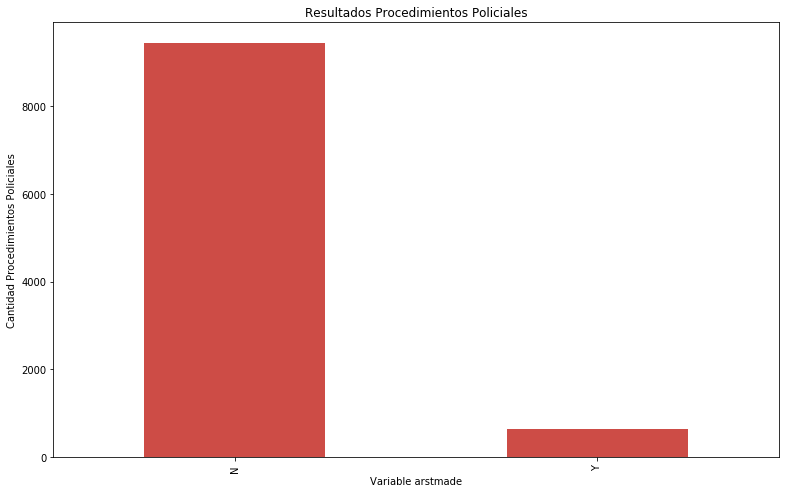

In [255]:
df_final['arstmade'].value_counts().plot(kind = 'bar', color = '#CD4C46')
plt.title("Resultados Procedimientos Policiales")
plt.xlabel("Variable arstmade")
plt.ylabel("Cantidad Procedimientos Policiales");


df_final['arstmade'].value_counts()

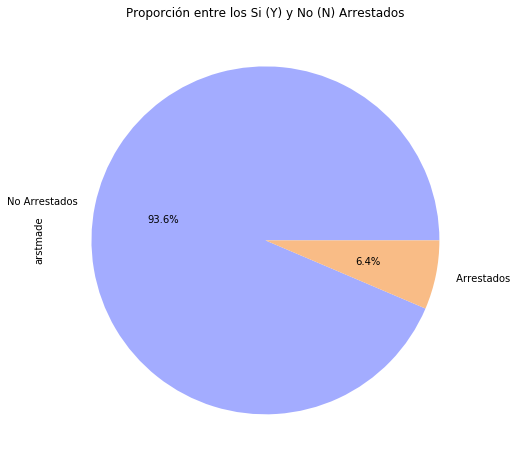

In [256]:
df_final['arstmade'].value_counts().plot(kind='pie', autopct="%.1f%%", colors = ['#a3acff','#f9bc86'], labels=["No Arrestados", " Arrestados"] ,title='Proporción entre los Si (Y) y No (N) Arrestados');


RESPUESTA: Podemos ver que la variable está *desbalanceada* hacia el evento negativo por lo que podemos deducir que en la mayor cantidad de los procedimientos policiales terminaron sin arresto. 

- 4.2.- Estudie la relación de la variable respuesta en comportamiento con la raza (race), comente.

In [257]:
df_arstmade_race = pd.DataFrame()
df_arstmade_race = df_final[['arstmade','race']].copy()
pd.crosstab(df_arstmade_race['arstmade'], df_arstmade_race['race'])


race,A,B,I,P,Q,U,W,Z
arstmade,,,,,,,,
N,279,5006,37,540,2368,66,902,234
Y,20,336,0,35,164,3,72,16


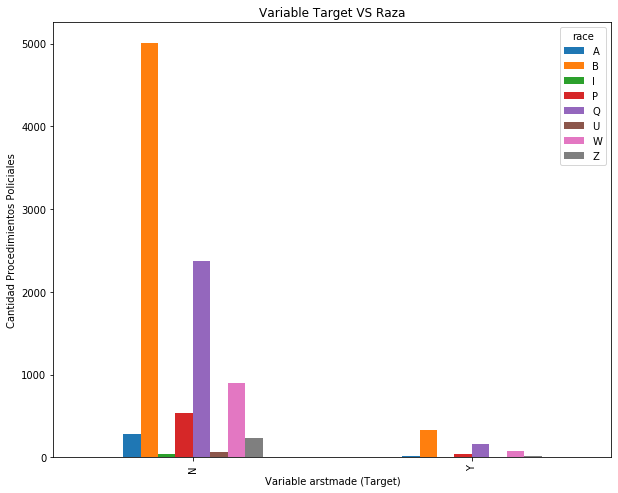

In [258]:
pd.crosstab(df_arstmade_race['arstmade'], df_arstmade_race['race']).plot.bar(figsize=(10,8))
plt.title("Variable Target VS Raza")
plt.xlabel("Variable arstmade (Target)")
plt.ylabel("Cantidad Procedimientos Policiales");

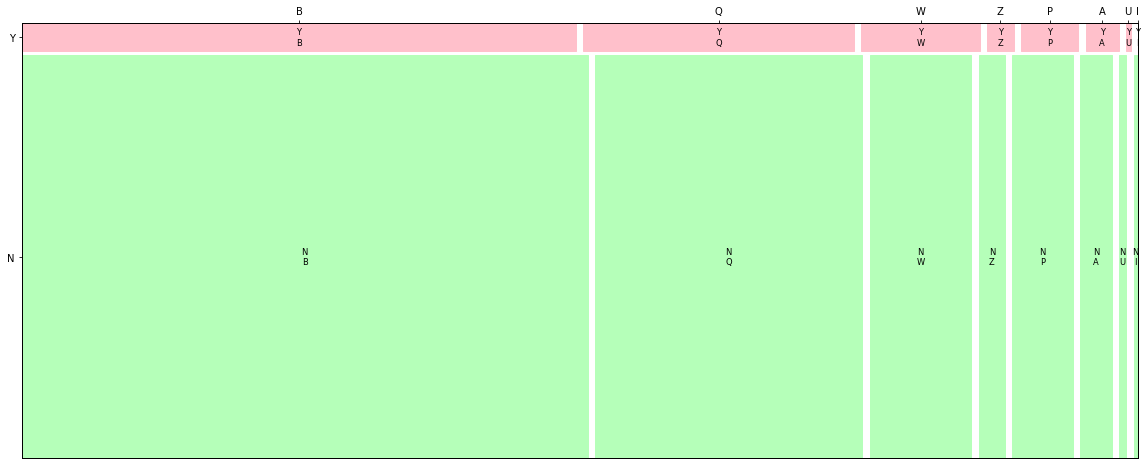

In [259]:
plt.rcParams['figure.figsize'] = (20,8)
props = lambda key: {'color': 'pink' if 'Y' in key else '#b5ffb9'}
mosaic(df_final, ['arstmade','race'],gap=0.01,horizontal=False,ax=None,properties=props);

- 4.3.a Estudie la relación de la variable respuesta en comportamiento con la sexo (sex), comente.

In [260]:
df_arstmade_sex = pd.DataFrame()
df_arstmade_sex = df_final[['arstmade','sex']].copy()
pd.crosstab(df_arstmade_sex['arstmade'], df_arstmade_sex['sex'])

sex,F,M,Z
arstmade,,,
N,586,8704,142
Y,64,574,8


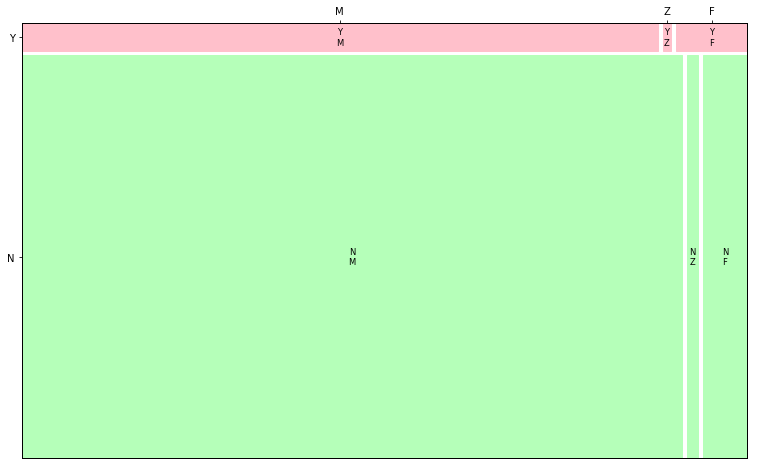

In [261]:
plt.rcParams['figure.figsize'] = (13,8)
props = lambda key: {'color': 'pink' if 'Y' in key else '#b5ffb9'}
mosaic(df_final, ['arstmade','sex'],gap=0.01,horizontal=False,ax=None, properties=props);




- 4.3.b Estudie la relación de la variable respuesta en comportamiento con la sexo y la edad en su conjunto, comente.

In [262]:
pd.crosstab([df_final['arstmade'],df_final['sex']],df_final['age'])

age           18   19   20   21   22   23   24   25   26   27   ...  69   70   \
arstmade sex                                                    ...             
N        F     33   35   29   36   23   24   30   21   18   18  ...    0    0   
         M    596  648  658  527  431  405  382  402  317  294  ...    5    3   
         Z      7   14   14   10    9    4    3    3    9    5  ...    0    0   
Y        F      3    0    8    3    3    5    4    0    3    1  ...    0    0   
         M     53   28   39   36   26   27   26   21   17   14  ...    0    0   
         Z      0    0    0    0    0    0    1    1    0    1  ...    0    0   

age           71   72   73   74   81   83   99   100  
arstmade sex                                          
N        F      0    0    0    0    1    0    0    0  
         M      1    4    3    1    0    2   15    1  
         Z      0    0    0    0    0    0    1    0  
Y        F      0    0    0    0    0    0    0    0  
         M      0    0    0    0    0    0    1    0  
         Z      0    0    0    0    0    0    0    0  

[6 rows x 61 columns]

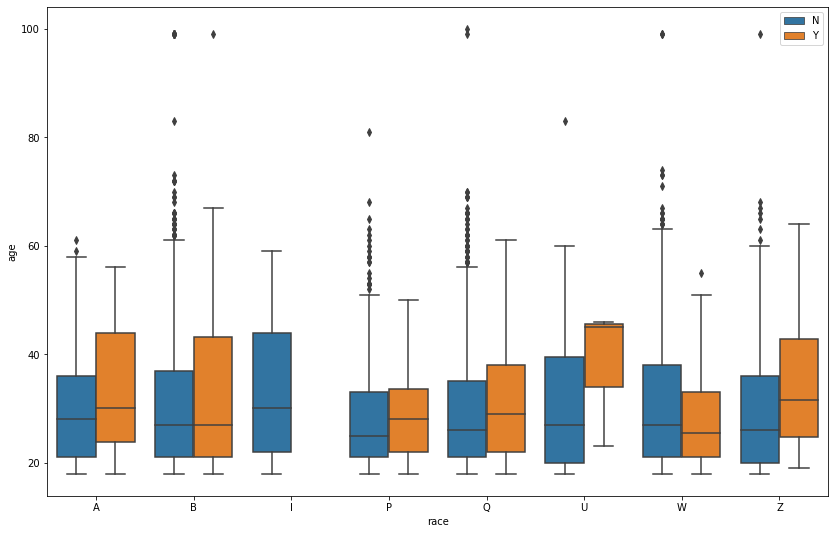

In [263]:
fig_dims = (14, 9)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="race", y="age", hue='arstmade', data=df_final);
plt.legend(bbox_to_anchor=(1.0, 1.0));

- 4.4 Recodifique la variable respuesta a 1 y 0. Donde 0 es N y 1 es Y

In [264]:
df_final['arstmade'] = df_final['arstmade'].apply(lambda x : 1 if x == 'Y' else 0);
df_final['arstmade'].unique()

[0, 1]
Categories (2, int64): [0, 1]

- 4.5 Muestre en un gráfico la probabilidad que un individuo sea arrestado,condicional al género y a la raza. ¿qué implicancias éticas tienen algunas conclusiones de lo que observa?.

In [265]:
# Considerando y Filtrando todos los Arrestados
df_arrestados = df_final[(df_final['arstmade']==1)]
df_arrestados = df_arrestados[['sex','race']]
pd.crosstab(df_arrestados['sex'],df_arrestados['race']).apply(lambda r: r/len(df_arrestados), axis=1)

race,A,B,P,Q,U,W,Z
sex,,,,,,,
F,0.001548,0.060372,0.004644,0.017028,0.000000,0.015480,0.000000
M,0.029412,0.459752,0.049536,0.233746,0.003096,0.095975,0.017028
Z,0.000000,0.000000,0.000000,0.003096,0.001548,0.000000,0.007740


In [266]:
pd.crosstab(df_arrestados['sex'],df_arrestados['race']).apply(lambda r: r/len(df_arrestados), axis=1)

race,A,B,P,Q,U,W,Z
sex,,,,,,,
F,0.001548,0.060372,0.004644,0.017028,0.000000,0.015480,0.000000
M,0.029412,0.459752,0.049536,0.233746,0.003096,0.095975,0.017028
Z,0.000000,0.000000,0.000000,0.003096,0.001548,0.000000,0.007740


# 5.- Determinar si el procedimiento policial concluirá en alguna acción violenta. (0.5 puntos)

Los atributos que tienen el prefijo pf (`['pf_hands'],['pf_wall'], ['pf_grnd'], ['pf_drwep'], ['pf_ptwep'],['pf_baton'],['pf_hcuff'], ['pf_pepsp'] y ['pf_other']`) indican si hubo fuerza fisica utilizada por el oficial al momento del procedimiento, con la marca 'Y'. 

Genere una nueva variable llamada 'violencia' la cual sea 1 si en cualquiera de las 9 variables pf hubo alguna 'Y', y 0 en otro caso. Luego indique el porcentaje de casos que terminaron con violencia.

In [268]:
col_violence = ['pf_hands','pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep','pf_baton','pf_hcuff', 'pf_pepsp', 'pf_other']

# verificar que todas las columnas mencionadas estén con el valor N  y si alguno es Y retornar un 1 si no retornar 0
df_final['violence'] = (df_final[col_violence] == "Y").any(axis="columns")
df_final['violence'] = df_final['violence'].apply(lambda x : 1 if x == True else 0)
df_final['violence'].unique()

array([0, 1])

In [269]:
pd.crosstab(index=df_final['violence'], columns="count")

col_0,count
violence,
0,7641
1,2437


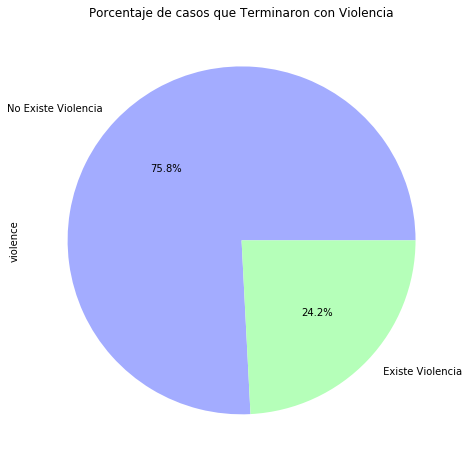

In [270]:
df_final['violence'].value_counts().plot(kind='pie', autopct="%.1f%%",colors = ['#a3acff','#b5ffb9'],labels=["No Existe Violencia", " Existe Violencia"], title='Porcentaje de casos que Terminaron con Violencia');


# 6.- Modelación (2 puntos)

- 6.1 Genere las variables dummies correspondientes (Tenga cuidado de no utilizar variables que expliquen lo mismo, ¡recuerde que acaba de crear una variable a partir de otras!, además recuerde que creó una variable numérica que es una categoría :) ). Luego genere los sets de train-test  utilizando el año 2009 para entrenar, y el año 2010 para testear. (0.5 pts)

- 6.2  Entrene 4 modelos de clásificación y reporte el mejor modelo bajo algún criterio. Utilice validación cruzada de al menos 2 folds para probar distintos hiperparámetros para cada modelo (puede probar cualquier hiperparámetro, pero debe ser al menos uno). (1.5 pts)

In [271]:
df_final.drop(columns=col_violence, inplace= True)
df_final

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,city,sector,beat,dettypcm,linecm,month,year,meters,age,violence
0,A,O,P,P,Y,N,0,N,Y,N,...,BRONX,G,7,CM,1,4,2009,1.7526,24,0
2,1,O,P,V,Y,N,0,N,N,N,...,BRONX,E,U,CM,1,10,2009,1.9050,21,0
3,A,O,P,P,Y,N,0,N,Y,N,...,BROOKLYN,J,4,CM,1,12,2009,1.6510,22,0
4,A,O,P,P,Y,Y,0,N,Y,N,...,QUEENS,H,U,CM,1,12,2009,1.6764,18,0
5,1,I,T,V,Y,N,0,N,N,I,...,MANHATTAN,F,16,CM,1,5,2009,1.7272,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,1,O,P,P,Y,Y,0,N,N,N,...,QUEENS,A,U,CM,1,6,2010,1.6764,21,0
6008,1,O,H,P,Y,N,0,N,Y,N,...,BROOKLYN,I,U,CM,1,9,2010,1.7780,20,1
6009,A,O,P,R,Y,N,0,N,N,N,...,BROOKLYN,A,U,CM,1,7,2010,1.7018,23,0
6011,1,O,P,P,Y,N,0,N,N,I,...,QUEENS,E,U,CM,1,11,2010,1.8034,19,1


In [272]:
df_y = df_final['arstmade']
y_train = df_final[df_final['year'] == 2009]['arstmade']
y_test= df_final[df_final['year'] == 2010]['arstmade']
df_x = df_final.drop(columns = 'arstmade')
df_dummies = pd.get_dummies(df_x, drop_first= True)
X_train = df_dummies[df_dummies['year']== 2009]
X_test = df_dummies[df_dummies['year']== 2010]
df_final.head()

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,city,sector,beat,dettypcm,linecm,month,year,meters,age,violence
0,A,O,P,P,Y,N,0,N,Y,N,...,BRONX,G,7,CM,1,4,2009,1.7526,24,0
2,1,O,P,V,Y,N,0,N,N,N,...,BRONX,E,U,CM,1,10,2009,1.9050,21,0
3,A,O,P,P,Y,N,0,N,Y,N,...,BROOKLYN,J,4,CM,1,12,2009,1.6510,22,0
4,A,O,P,P,Y,Y,0,N,Y,N,...,QUEENS,H,U,CM,1,12,2009,1.6764,18,0
5,1,I,T,V,Y,N,0,N,N,I,...,MANHATTAN,F,16,CM,1,5,2009,1.7272,47,0


### Supporting Vector Machine

In [273]:
# Se define los hiperparametros a revisar
param_grid = { 'kernel':['poly','rbf'],'C': [2, 5, 10, 15] }

# Definir el modelo de Validacion Cruzada
svm_model_cv = GridSearchCV(SVC(), param_grid, cv=2) 
svm_model_cv.fit(X_train, y_train)

# Veamos cuales son los mejores hiperparametros
svm_model_cv.best_params_

{'C': 2, 'kernel': 'poly'}

In [274]:
# Se construye el modelo Supporting Vector Machine 
svm_model = SVC() #rbf, sigmoid, poly # 0,0001 < gamma < 10, 0,1 < C < 100
svm_model.fit(X_train, y_train)

# Se predice
svm_pred = svm_model.predict(X_test)
svm_pred_cv = svm_model_cv.predict(X_test)
#repotes
print(classification_report(y_test, svm_pred))
pd.crosstab(y_test, svm_pred) 

print(classification_report(y_test, svm_pred_cv))
pd.crosstab(y_test, svm_pred_cv) 


              precision    recall  f1-score   support

           0       0.93      1.00      0.97      4749
           1       0.00      0.00      0.00       342

    accuracy                           0.93      5091
   macro avg       0.47      0.50      0.48      5091
weighted avg       0.87      0.93      0.90      5091

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      4749
           1       0.00      0.00      0.00       342

    accuracy                           0.93      5091
   macro avg       0.47      0.50      0.48      5091
weighted avg       0.87      0.93      0.90      5091



col_0,0
arstmade,
0,4749
1,342


### Naive Bayes

In [275]:
# Se construye el modelo Naive Bayes
modelo_nb = MultinomialNB(fit_prior=False) ##High=0 Low=1 Medium=2
modelo_nb.fit(X_train, y_train) # no es necesario la estandarización

# Se predice
nb_pred = modelo_nb.predict(X_test)

#repotes
print(classification_report(y_test, nb_pred))
pd.crosstab(y_test, nb_pred)

              precision    recall  f1-score   support

           0       0.99      0.43      0.60      4749
           1       0.11      0.96      0.19       342

    accuracy                           0.46      5091
   macro avg       0.55      0.69      0.40      5091
weighted avg       0.93      0.46      0.57      5091



col_0,0,1
arstmade,,
0,2039,2710
1,15,327


### Arbol de decisiones

In [276]:
print(y_test)

0       0
1       0
2       0
3       0
4       0
       ..
6007    0
6008    0
6009    0
6011    0
6012    0
Name: arstmade, Length: 5091, dtype: category
Categories (2, int64): [0, 1]


In [277]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 10)}   #Grilla de valores a probar

model_2=DecisionTreeClassifier()

nfolds=10
dtree_gscv = GridSearchCV(model_2, param_grid, cv=nfolds)
dtree_gscv.fit(X_train, y_train)
dtree_gscv.best_params_



{'criterion': 'entropy', 'max_depth': 4}

In [278]:
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10).fit(X_train, y_train)
dt_pred = model.predict(X_test)

#repotes
print(classification_report(y_test, dt_pred))
pd.crosstab(y_test, dt_pred)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4749
           1       0.75      0.58      0.66       342

    accuracy                           0.96      5091
   macro avg       0.86      0.79      0.82      5091
weighted avg       0.96      0.96      0.96      5091



col_0,0,1
arstmade,,
0,4682,67
1,142,200


### Random forest

In [279]:
from sklearn.ensemble import RandomForestClassifier

bosque = RandomForestClassifier(n_estimators=1000, criterion='entropy').fit(X_train, y_train)

y_pred_bosque=bosque.predict(X_test)

print(classification_report(y_test, y_pred_bosque))
pd.crosstab(y_test, y_pred_bosque)
print(bosque.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4749
           1       0.87      0.49      0.63       342

    accuracy                           0.96      5091
   macro avg       0.92      0.74      0.81      5091
weighted avg       0.96      0.96      0.96      5091

0.9611078373600471


# Bonus (0.5 pts)

¿Que puede hacer para mejorar la predicción de los modelos?

In [280]:
+ Para mejorar el modelo de **SVM** ocupe validación cruzada para mejorar los hiperparametros. 

SyntaxError: invalid syntax (<ipython-input-280-a734c4646a85>, line 1)